# **Lab 7 (SOLUTIONS)**



TI3155TU Deep Learning (2024 - 2025)



Adapted by Elena Congeduti from TU Delft CS4240 Deep Learning course.


# Instructions
**For this lab, we recommend working on Google Colab as it provides direct support for the TensorBoard library. To do this, select the 'Open in Colab' option from the notebook's homepage menu.**

Alternatively, you can work locally. In this case, you will need to set up your own virtual environment. Check the Lab Instructions in [Learning Material](https://brightspace.tudelft.nl/d2l/le/content/682797/Home?itemIdentifier=D2L.LE.Content.ContentObject.ModuleCO-3812764) on Brightspace for detailed information on the virtual environment configuration.

These labs include programming exercises and insight questions. Follow the instructions in the notebook. Fill in the text blocks to answer the questions and write your own code to solve the programming tasks within the designated part of the code blocks:

```python
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Solutions will be shared the week after the lab is published. Note that these labs are designed for practice and are therefore **ungraded**.

In [15]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import math

!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Additional Setup to use MNIST1D
!pip install mnist1d

import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 1 MNIST-1D Classification

To better see the effect of overfitting and different regularization techniques we will be using again the MNIST-1D dataset since it is very lightweight and can be easily trained without a GPU. You can find more information on MNIST-1D [here](https://greydanus.github.io/2020/12/01/scaling-down/).



Unlike regular MNIST, which consists of two-dimensional grayscale images, MNIST-1D contains one-dimensional waveforms which are automatically generated from a set of 10 templates. Run the following cell to get an overview of the different labels and the corresponding 1D waveform templates in MNIST-1D.

Templates for the MNIST-1D dataset:


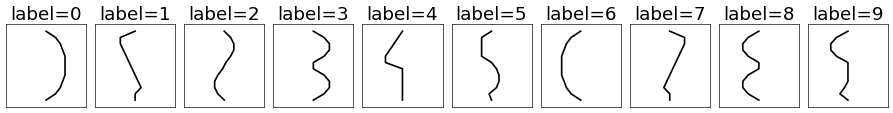

In [16]:
#Get templates of numbers in the dataset
templates = get_templates()

#Plot the different templates
print("Templates for the MNIST-1D dataset:")
fig = plot_signals(templates['x'], templates['t'], labels=templates['y'], ratio=1.33, dark_mode=False)

We will now load and preprocess the dataset, and display a sample for each of the 10 classes. To understand how the MNIST-1D shapes have been generated from the templates you can take a look at [this video](https://greydanus.github.io/assets/scaling-down/construction.mp4).

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


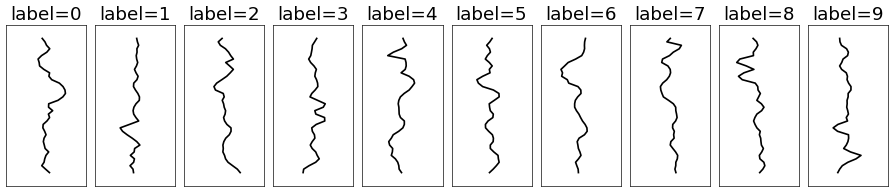

In [21]:
# Load dataset
data = get_dataset(get_dataset_args(), path='./mnist1d_data.pkl',

                   download=False, regenerate=True)


# Set the batch size for training & testing
b_size = 100

# Convert 1D MNIST data to pytorch tensors
tensors_train = torch.Tensor(data['x']), torch.Tensor(data['y']).long()
tensors_test = torch.Tensor(data['x_test']),torch.Tensor(data['y_test']).long()

# Create training set and test set from tensors
train_set = TensorDataset(*tensors_train)
test_set = TensorDataset(*tensors_test)

# Create dataloaders from the training and test set for easier iteration over the data
train_loader = DataLoader(train_set, batch_size=b_size)
test_loader = DataLoader(test_set, batch_size=b_size)

# Get some data and check for dimensions
input,label = next(iter(train_loader))

# Check whether the data has the right dimensions
assert(input.shape == torch.Size([b_size, 40]))
assert(label.shape == torch.Size([b_size]))

# Display samples from dataset
fig = plot_signals(templates['x'], templates['t'], labels=templates['y'],
                   args=get_dataset_args(), ratio=2.2, do_transform=True)

Let us now train a simple (but rather large) fully connected network to classify the MNIST-1D samples. In the forward pass you see that the input of a layer is summed to its output, i.e. `h = h + F.relu(self.fc(h))`. These represent *residual connections* [[paper](https://arxiv.org/abs/1512.03385)] and are introduced to mitigate the problem of vanishing gradient for very deep networks. The network is defined as follows:

In [22]:
class FCNet(nn.Module):

    """
    Simple fully connected neural network with residual connections in PyTorch.
    Layers are defined in __init__ and forward pass implemented in forward.
    """

    def __init__(self):
        
        super(FCNet, self).__init__()

        self.fc1 = nn.Linear(40, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 500)
        self.fc6 = nn.Linear(500, 10)

    def forward(self, x):

        h = F.relu(self.fc1(x))
        h = h + F.relu(self.fc2(h))
        h = h + F.relu(self.fc3(h))
        h = h + F.relu(self.fc4(h))
        h = h + F.relu(self.fc5(h))

        return self.fc6(h)

# Print network architecture using torchsummary
summary(FCNet(), (40,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]          20,500
            Linear-2                  [-1, 500]         250,500
            Linear-3                  [-1, 500]         250,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                  [-1, 500]         250,500
            Linear-6                   [-1, 10]           5,010
Total params: 1,027,510
Trainable params: 1,027,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.92
Estimated Total Size (MB): 3.94
----------------------------------------------------------------


It is a good common practice to define separate functions for the training and validation steps inside an epoch. These functions are then called once per epoch during training, which significantly cleans up the code for the training loop.

In [23]:
def train(train_loader, net, optimizer, criterion):

    """
    Trains network for one epoch in batches.

    Args:

        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).

    """

    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        
        #evaluate loss 
        loss = criterion(outputs, labels)
        
        #backward pass
        #Computing derivatives
        loss.backward()
        
        #update step
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

def test(test_loader, net, criterion):

    """
    Evaluates network in batches.
    Args:

        test_loader: Data loader for test set.
        net: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():

        # iterate through batches
        for data in test_loader:

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward pass
            outputs = net(inputs)
            
            #evaluate loss
            loss = criterion(outputs, labels)

            # keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss/len(test_loader), 100 * correct / total

We have already seen how Tensorboard can provide powerfull visualizations. In the following exercise you will use it to log and visualize the training curves of your network.



The following cell will train your network for 100 epochs and write the results per epoch to tensorboard (this might take a few seconds).

In [ ]:
#Create a writer to write to Tensorboard
writer = SummaryWriter()

#Set the number of epochs to for training
epochs = 100

# Create instance of Network
net = FCNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc,'Test':test_acc} , epoch)

print('\n Finished Training')
writer.flush()
writer.close()

Note: if you are running this notebook on Kaggle you will have to write your own visualization functions to plot the training curves as Tensorboad is not directly supported. Otherwise switch to Google Colab as suggested in the initial instructions.  

Now that the training is done successfully you can view the training curves of your network in tensorboard. It might take a few seconds until it is loaded.



If you later run another experiment and want to also see those results click the refresh icon in the top right corner. image.png

In [24]:
# For Google Colab users only, local users run the next cell
# Run Tensorboard

%tensorboard --logdir runs/

Reusing TensorBoard on port 6006 (pid 99), started 0:13:16 ago. (Use '!kill 99' to kill it.)

In [ ]:
# For local users only
# Uncomment the last line
# run this cell once and wait for it to time out
# run this cell a second time and you should see the board

#%tensorboard --logdir runs/ --host localhost

In [ ]:
# To completely clean your tensorboard uncomment and run the following command.
!rm -r runs

****

**Question 1.1:**

Can you discuss the training curves and the accuracy progression?


<font color='green'> We see that the training loss is approximately zero and the model reaches perfect training accuracy. However, the test accuracy reaches a much lower plateau value after 20 epochs and from that point the test loss starts increasing significatively. This is a strong indication of overfitting: the model has learned to perfectly fit the training set but performs poorly on the unseen test data.

</font>



****

****

**Question 1.2:**

Would early stopping help to improve the performance of the model?


<font color='green'> If we stop the training process at the minimum of the test loss, that is around 10 epochs the final accuracy will still be quite low and the generalization gap quite high. So in this case, early stopping won't be of a great help.

</font>

****

However, drawing conclusions from a single experiment run can be misleading as the results can be heavily influenced by the randomness in network initialization and order of mini-batches. To address this issue, we re-implement the same training procedure for multiple runs. While Tensorboard lacks direct tools for visualizing averages and standard errors across multiple runs, we can still create plots to display the training curves and accuracy for different runs and compare them.



We first define our own function to visualize the average with error intervals.

In [26]:
def plot_loss_acs(train_avg, train_err, test_avg, test_err):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

  epochs = np.arange(np.shape(train_avg)[1])

  ax1.plot(epochs,train_avg[0], label='Train')
  ax1.fill_between(epochs,train_avg[0]+train_err[0],train_avg[0]-train_err[0], alpha=0.6)
  ax1.plot(epochs,test_avg[0], label='Test')
  ax1.fill_between(epochs,test_avg[0]+test_err[0],test_avg[0]-test_err[0], alpha=0.6)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  ax2.plot(epochs,train_avg[1], label='Train')
  ax2.fill_between(epochs,train_avg[1]+train_err[1],train_avg[1]-train_err[1], alpha=0.6)
  ax2.plot(epochs,test_avg[1], label='Test')
  ax2.fill_between(epochs,test_avg[1]+test_err[1],test_avg[1]-test_err[1], alpha=0.6)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.grid()
  ax2.legend()
  plt.tight_layout()
  plt.show()

****

**Task 1.3:** Complete the missing parts to implement multiple experimental runs of the training loop. It might take few minutes. [Hint: clean your tensorboard first].

****

100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



 Finished Training


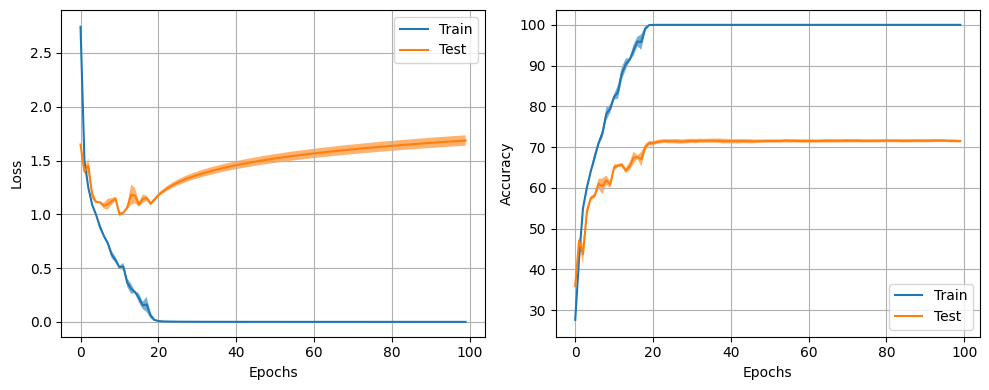

Final training accuracy 100
Final test accuracy 72


In [27]:
#Create a writer to write to Tensorboard
writer = SummaryWriter()

#Set the number of epochs to for training
epochs = 100

#Set the number of runs of the experiment
runs = 3

#Initialize arrays to store meatrics
train_losses = np.zeros((runs,epochs))
test_losses = np.zeros((runs,epochs))
train_acs = np.zeros((runs,epochs))
test_acs = np.zeros((runs,epochs))

for run in range(runs):

  # Create instance of Network
  net = FCNet()

  # Create loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=5e-1)

  #Shuffle test set
  test_loader = DataLoader(test_set, batch_size=b_size, shuffle =True)

  for epoch in tqdm(range(epochs)):

      train_loss, train_acc = train(train_loader, net, optimizer,criterion)
      test_loss, test_acc = test(test_loader,net,criterion)

      #Create a copy of the training and test metrics "detached" from future gradient computations
      train_losses[run,epoch] = train_loss.detach().numpy()
      test_losses[run,epoch] = test_loss.detach().numpy()
      train_acs[run,epoch] = train_acc
      test_acs[run,epoch] = test_acc

      #############################################################################
      #                            START OF YOUR CODE                             #
      #    Write measures to TensorBoard. Remember to distinguish different runs. #
      #############################################################################
      writer.add_scalars("Loss", {'Train '+str(run): train_losses[run,epoch], 'Test '+str(run):test_losses[run,epoch]}, epoch)

      writer.add_scalars("Accuracy", {'Train '+str(run): train_acs[run,epoch], 'Test '+str(run):test_acs[run,epoch]}, epoch)
      #############################################################################
      #                            END OF YOUR CODE                               #
      #############################################################################

print('\n Finished Training')
writer.flush()
writer.close()

#############################################################################
#                            START OF YOUR CODE                             #
#        Compute averages and standard errors over runs and store them as   #
#         train_loss_avg, train_loss_err, train_acs_avg, train_acs_err...   #
#############################################################################
train_loss_avg = np.mean(train_losses,axis=0)
test_loss_avg = np.mean(test_losses,axis=0)
train_acs_avg = np.mean(train_acs,axis=0)
test_acs_avg = np.mean(test_acs,axis=0)

train_loss_err = np.std(train_losses,axis=0)/np.sqrt(runs)
test_loss_err = np.std(test_losses,axis=0)/np.sqrt(runs)
train_acs_err = np.std(train_acs,axis=0)/np.sqrt(runs)
test_acs_err = np.std(test_acs,axis=0)/np.sqrt(runs)
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

train_avg = np.array([train_loss_avg,train_acs_avg])
test_avg = np.array([test_loss_avg,test_acs_avg])
train_err = np.array([train_loss_err,train_acs_err])
test_err = np.array([test_loss_err,test_acs_err])

plot_loss_acs(train_avg, train_err, test_avg, test_err)

print(f'Final training accuracy {train_acs_avg[-1]:.0f}')
print(f'Final test accuracy {test_acs_avg[-1]:.0f}')

****

**Question 1.4:**

Between epochs 10 and 20, we see the test loss beginning to rise, while at the same time, the accuracy improves. Can you think of a reason why this apparent contradiction might occur?

<font color='green'> Classification accuracy and loss are not necessarily exactly inversely correlated. The loss provides a continuous measure of the difference between the predicted probability distribution and the true, deterministic distribution, while accuracy quantifies the difference between the 'thresholded output' and the class label.</font>



<font color='green'> In general, a small change in the predicted probabilities might significantly affect accuracy but will have a minor impact on the loss. Consider a binary classification problem where an instance is incorrectly classified with a probability of $\hat p=0.49$. This instance contributes a value of $0$ to accuracy but results in a loss of $-\log(0.49)$. Assume that after some epochs, the new predicted probability is $\hat p=0.51$. Now the model assigns the correct label to the instance, which contributes a value of $1$ to accuracy, while the cross-entropy loss remains close to the previous value a $-\log(0.51)$.</font>



<font color='green'> Conversely, a significant change in predicted probabilities might have no effect on accuracy but can substantially impact the loss (think of what happens if the predicted probabilities become $\hat p=0.1$).</font>



<font color='green'>Therefore, one possible explanation is that subtle changes to incorrectly classified instances corrected their labels without significantly improving the loss. Meanwhile, other incorrectly classified instances saw their predictions deteriorate, causing the loss to increase.</font>



<font color='green'> Check also this [post](https://stats.stackexchange.com/questions/282160how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy).

</font>

****

We will proceed with the lab, using a single experimental run to ensure a reasonable execution time.


# 2 Overfitting and the learning curve



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/1024px-Overfitting.svg.png" alt="drawing" width="200" align="right" />



Neural networks are large and powerful function approximators. Our model with 1 027 510 (!) trainable parameters can easily learn a decision boundary for our dataset of merely 4 000 samples. But does that mean that our model will also correctly classify data samples it has not seen before? In other words, does our model generalize to unseen data?



A common practice is to divide a dataset into two different splits: a training set used to update the model parameters, and a test set which is only used to evaluate the model performance. The training curves show that although our model is able to classify all training samples with 100% accuracy, on the test set it has a rather disappointing average accuracy of only ~70%. This phenomenon is called **overfitting** and is illustrated in the image on the right: the green decision boundary is completely overfitted on the training samples, whereas the black decision boundary does not classify all training samples correctly but probably far more accurately models the true distribution of the data.



A lot of factors influence the extent to which a model overfits to dataset - most importantly the size of the training set. The less samples a model can learn from, the more difficult it is to learn the true distribution of the data and the more the model will overfit. A **learning curve** shows the test accuracy or test loss of a model with respect to the number of training samples. The following code block will train the model using a varying number of samples and plot the learning curve. This can take a few minutes.

In [28]:
#Learning curves plot

def plot_learning_curve(train_losses, test_losses, train_acs, test_acs):

  fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(n_samples, train_losses, marker='o', label='Train')
  ax1.plot(n_samples, test_losses, marker='o', linestyle='--', label='Test')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Training set size')
  ax1.legend()
  ax1.grid()

  ax2.plot(n_samples, train_acs, marker='o', label='Train')
  ax2.plot(n_samples, test_acs, marker='o', linestyle='--', label='Test')
  ax2.set_xlabel('Training set size')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid()
  plt.show()


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


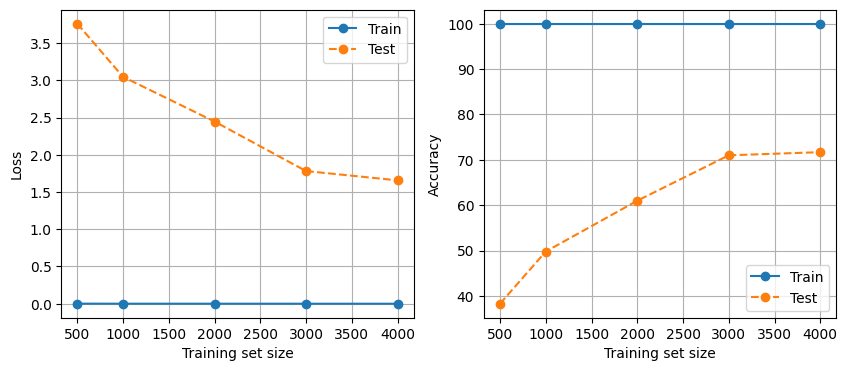

In [29]:
train_acs = []
test_acs = []
train_losses = []
test_losses = []

n_samples = [500, 1000, 2000, 3000, 4000]

# Train model for different number of training samples
for n in n_samples:

    # Take subset of first n samples in training set
    train_subset = torch.utils.data.Subset(train_set, range(n))

    # Create new dataloader
    train_loader = DataLoader(train_subset,batch_size=b_size)

    # Create instance of Network
    net = FCNet()

    # Create loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=5e-1)

    # Set the number of epochs to for training
    epochs = 100

    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        # Train on data
        train_loss, train_acc = train(train_loader, net, optimizer, criterion)

        # Test on data
        test_loss, test_acc = test(test_loader, net, criterion)

    # Store accuracies
    train_acs.append(train_acc)
    test_acs.append(test_acc)
    train_losses.append(train_loss.detach())
    test_losses.append(test_loss.detach())

plot_learning_curve(train_losses, test_losses, train_acs, test_acs)

****

**Question 2.1:** What does the learning curve show?

<font color='green'> The figure shows that the larger the training set, the higher the test accuracy and the lower the test loss of the model become. The training accuracy and training loss are a constant 100% and ~0, respectively. For small sizes of the training set, the generalization gap is very high while the training loss remains close to $0$. This is a clear indication of overfitting.

</font>

****

To magnify the effect of the various regularization methods we will from now on use a reduced training set size of 500 samples.

In [30]:
# Take subset of first 500 samples in training set
train_subset = torch.utils.data.Subset(train_set, range(500))

# Create new dataloader
train_loader = DataLoader(train_subset,batch_size=b_size)

We will train our model on this subset to get a baseline in Tensorboard to which we can compare our regularized models.



It might be useful to clean your Tensorboard at this point.

In [31]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Create instance of Network
net = FCNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1)

# Set the number of epochs to for training
epochs = 100

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, epoch)
    writer.add_scalars('Accuracy',{'Train': train_acc,'Test':test_acc} , epoch)

print('\n Finished Training')
writer.flush()
writer.close()

100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


 Finished Training


You will see that the training loss will continuously decrease, whereas the test loss will start to increase again at some point. Like the plateauing test accuracy, an increasing test loss is another indication of overfitting.

# 3 L2 Regularization



If our neural network is able to learn such a complex decision boundary that it completely overfits on the training set, we would perhaps like to reduce its expressive power. An obvious way would be to reduce the number of parameters in our model, but that does not allow for much flexibility. Instead, we would rather have our model to prefer simpler decision boundaries without putting a hard limit on its expressivity. This is where L2 regularization comes into play:

$$L = L_0 + \frac{\lambda}{2}\sum_w w^2 $$

Here, the total loss $L$ consists of the original task-specific loss $L_0$, e.g. cross-entropy, and the sum of the squared value of all network parameters $w$ (weights and biases), where $\lambda$ specifies the relative weight of the two components. $\lambda$ is a so-called hyper-parameter which needs to be specified before training, similar to the `epochs` parameter. This loss function thus encourages the network to learn small parameters, i.e. it minimizes the L2 norm of the parameters.



It might not be directly clear why this would solve our overfitting problem - an intuitive explanation is that the output of a neural network with small weights is not very susceptible to small changes in the input and therefore its recision boundary is relatively smooth. For further reading and a very nice example we'd like to refer to [this excellent online book](http://neuralnetworksanddeeplearning.com/chap3.html#why_does_regularization_help_reduce_overfitting).



We will now implement L2 normalization in our training loop. For this we will need to add the extra regularization term to our loss function. We provide you with some hints as to how to do this.

****

**Task 3.1:** Add the L2 regularization to the loss function. The total loss becomes:``loss = loss + 0.5*wd*l2``, where l2 is the sum of the squared value of all parameters and wd the relative weight of the L2 penalty that we normally refer to as $\lambda$. [Hint: loop through the network parameters using ``for p in net.parameters():``].  

****

In [32]:
def train_wd(train_loader, net, optimizer, criterion, wd):

    """
    Trains network for one epoch in batches.
    Uses custom L2 regularization in loss function.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        wd: Weight decay (L2 penalty)

    """
    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Initialize L2 penalty as 0
        l2 = 0

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################
        # Loop through network parameters
        for p in net.parameters():
            l2 = l2 + torch.pow(p,2).sum()
        loss = loss + 0.5*wd*l2
        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

Now again train the network on the small training subset of MNIST-1D and compare the training curves with those of the baseline.

Do not forget to hit refresh image.png in the top right corner of Tensorboard to display the results and compare with the baseline.


In [33]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Create instance of Network
net = FCNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1)

# Set the number of epochs to for training
epochs = 100

# Set weighing factor for L2 regularization
wd = 3e-3

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Train on data
    train_loss, train_acc = train_wd(train_loader,net,optimizer,criterion,wd)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    writer.add_scalars('Loss', {'Train': train_loss, 'Test':test_loss}, epoch)
    writer.add_scalars('Accuracy',{'Train': train_acc,'Test':test_acc} , epoch)


print('Finished Training')
writer.flush()
writer.close()

100%|██████████| 100/100 [00:10<00:00,  9.55it/s]

Finished Training


****

**Question 3.2:** What is the effect of the regularization term?


<font color='green'> If your implementation is correct the test loss will not increase as much anymore, indicating that the network is overfitting less on the training set. Likewise, the test accuracy should be slightly higher for the regularized model. Keep always in mind that you are looking at a single run, so due to the random nature of training runs, this might not always be the case.

</font>

****

In PyTorch, *weight decay*, which is simply another name for L2 regularization, is very conveniently built into the SGD optimizer.

****

**Task 3.3:** Have a look at the documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) and initialize the optimizer with the proper settings to train the network using the PyTorch built-in weight decay functionality. Set the weighting factor $\lambda$ for L2 regularization to 3e-3 as before.

****

In [34]:
#Create a writer to write to tensorboard
writer = SummaryWriter()

# Create instance of Network
net = FCNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()

########################################################################
#                            START OF YOUR CODE                        #
########################################################################
optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=3e-3)
########################################################################
#                          END OF YOUR CODE                            #
########################################################################

#Set the number of epochs to for training
epochs = 100

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, epoch)
    writer.add_scalars('Accuracy',{'Train': train_acc,'Test':test_acc} , epoch)

print('Finished Training')
writer.flush()
writer.close()

100%|██████████| 100/100 [00:09<00:00, 11.08it/s]

Finished Training


Have a look again at the loss curves in Tensorboard - you should see the same effect as with our own L2 regularization above.

****

**Question 3.4:** Can you think of a reason why the training losses with PyTorch and our own implementation do not look similar? What do you think PyTorch returns as loss and what did we plot in our own implementation? 


<font color ='green'> The PyTorch build-in function uses the regularization term only during the optimization part, that is when the method `backward` is called but not during the forward pass. So the loss reported corresponds to the actual cross entropy loss that can be used for comparison. In our implementation, the training loss accounts also for the regularization term. </font>

****

# 4 Early stopping



Instead of training a neural network for a fixed amount of epochs we can choose to halt training when the network starts to overfit on the training data. This is called **early stopping**.



For early stopping we continuously monitor the performance of the model on a separate *validation set* and stop when a certain metric, e.g. the accuracy, no longer improves. In practice this metric will not improve monotonously but will go up and down due to the stochastic nature of deep neural network training. Therefore often a certain *patience* is used, i.e. training is halted after the metric has not improved for a certain number of epochs. The patience is a hyper-parameter to be specified before training.



You might wonder why we need a separate validation test and do not simply use the test set to monitor the network performance. In general we always use a separate validation set for monitoring network performance and tuning hyper-parameters because we do not want to overfit these settings to the specifities of our test set. This way the performance on the test set remains a true measure of how well our model generalizes.



Let us start by making the validation set. Since we are only using the first 500 samples of the training set, we can use samples 500-1500 for validation.

In [35]:
# Make validation set - take samples 500-1500 from training set for convenience
val_set = torch.utils.data.Subset(train_set, range(500,1500))

# Create new dataloader
val_loader = DataLoader(val_set,batch_size=b_size)

You will now implement early stopping in the training loop. In short, the pseudo code for early stopping can be written as:

```python

for i in range(epochs):

    train(model)

    metric = validate(model)

    if metric > metric_best:

        metric_best = metric

        reset patience_counter

    else:

        increment patience_counter

        if patience_counter == patience:

            halt training

```




****

**Task 4.1:** Set the value for the `patience`. Then implement early stopping. [Hint: use 'break' to break out of the training loop.]

****

In [36]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Create instance of Network
net = FCNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=3e-3)

# Set the number of epochs to for training
epochs = 100

# Patience - how many epochs to keep training after accuracy has not improved
patience = 0

# Initialize early stopping variables
val_acc_best = 0
patience_cnt = 0

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on validation set
    val_loss, val_acc = test(val_loader,net,criterion)

    writer.add_scalars("Loss", {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)

    ########################################################################
    #                            START OF YOUR CODE                        #
    ########################################################################

    if val_acc > val_acc_best:
        val_acc_best = val_acc
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            break
    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

# Test on test set
test_loss, test_acc = test(test_loader,net,criterion)
print('\n Finished Training')
print('Validation accuracy:\t{:.2f}'.format(val_acc))
print('Test accuracy:\t\t{:.2f}'.format(test_acc))

writer.flush()
writer.close()

100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


 Finished Training
Validation accuracy:	37.90
Test accuracy:		38.30


****

**Question 4.2:** Do you think early stopping really improves the model performance in this case?

****

# 5 Dropout



Dropout is a regularization method that modifies the network architecture itself rather than the way the network is optimized. A Dropout layer deactivates a random fraction $p$ of the neurons in a layer during a training iterations by setting them to zero. After performing the forward and backward pass for the current iteration, a different set of neurons is deactivated.



There are different explanations for the regularizing effect of Dropout, most popularly:

* When deactivating a different set of neurons in each training iteration, it is like we are training many different models. The final model, where all neurons are active, will then act as a model ensamble.

* A related explanation is that a neuron becomes less reliant on the presence of other specific neurons and is therefore forced to learn a robust feature that works with many different sets of neurons. This can be seen as noise injection, which makes the neurons more robust to small peturbations in the input and in that sense makes it somewhat similar to L2 regularization.



Dropout is very easy to use in PyTorch. Have a look at the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and implement some Dropout layers in our model.

****

**Task 5.1:** Set the parameter `p` and add some Droupout layers. Then modify the forward pass to include the Droupout layers.

****

In [37]:
class FCNet_do(nn.Module):

    """
    Simple fully connected neural network with residual connections and dropout
    layers in PyTorch. Layers are defined in __init__ and forward pass
    implemented in forward.

    """

    def __init__(self):
        
        super(FCNet_do, self).__init__()
        
        self.fc1 = nn.Linear(40, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 500)
        self.fc6 = nn.Linear(500, 10)

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################

        p = 0.4
        self.do1 = torch.nn.Dropout(p=p)
        self.do2 = torch.nn.Dropout(p=p)

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################

        h = F.relu(self.fc1(x))
        h = self.do1(h + F.relu(self.fc2(h)))
        h = h + F.relu(self.fc3(h))
        h = self.do2(h + F.relu(self.fc4(h)))
        h = h + F.relu(self.fc5(h))

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        return self.fc6(h)

In [38]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Create instance of Network
net = FCNet_do()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=3e-3)

#Set the number of epochs to for training
epochs = 100

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    writer.add_scalars("Loss", {'Train': train_loss, 'Test': test_loss}, epoch)

    writer.add_scalars('Accuracy', {'Train': train_acc, 'Test': test_acc}, epoch)

print('Finished Training')
writer.flush()
writer.close()

100%|██████████| 100/100 [00:09<00:00, 10.86it/s]

Finished Training


****

**Question 5.2:**  Do you think Dropout really improves the model performance in this case?

****

**That's all for this lab, see you in the next one!**

**Feedback Form:** please fill in the following form to provide feedback https://forms.office.com/e/fbeyeBH4BS